In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from tqdm.notebook import tqdm

sheet_url = "https://docs.google.com/spreadsheets/d/1ZzaeMgNYnxvriYYpe8PE7uMEblTI0GV5GIVUnsP-sBs/export?format=csv"

wallet_df = pd.read_csv(sheet_url)

wallet_df.head(2)

,wallet_id
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3
1,0x06b51c6882b27cb05e712185531c1f74996dd988


In [7]:
wallets = wallet_df["wallet_id"].dropna().str.lower().tolist()

In [24]:
SUBGRAPH_URL = "https://api.thegraph.com/subgraphs/name/graphprotocol/compound-v2"

def run_query(query):
    try:
        response = requests.post(SUBGRAPH_URL, json={'query': query})
        if response.status_code == 200:
            return response.json()
    except Exception as e:
        print(f"Error: {e}")
    return {}


In [25]:
def fetch_account_activity(wallet):
    query = f"""
    {{
      account(id: "{wallet}") {{
        tokens {{
          supplyBalanceUnderlying
          borrowBalanceUnderlying
        }}
      }}
      borrowEvents(where: {{borrower: "{wallet}"}}) {{
        amount
      }}
      repayEvents(where: {{payer: "{wallet}"}}) {{
        amount
      }}
      liquidationEvents(where: {{borrower: "{wallet}"}}) {{
        amountRepaid
      }}
    }}
    """
    return run_query(query)


In [26]:
def compute_features(wallet, data):
    features = {
        "wallet_id": wallet,
        "total_borrows": 0,
        "total_repayments": 0,
        "num_liquidations": 0,
        "net_balance": 0,
        "repayment_ratio": 0,
    }

    borrow_events = data.get("data", {}).get("borrowEvents", [])
    repay_events = data.get("data", {}).get("repayEvents", [])
    liquidations = data.get("data", {}).get("liquidationEvents", [])
    tokens = data.get("data", {}).get("account", {}).get("tokens", [])

    features["total_borrows"] = sum(float(b.get("amount", 0)) for b in borrow_events)
    features["total_repayments"] = sum(float(r.get("amount", 0)) for r in repay_events)
    features["num_liquidations"] = len(liquidations)

    supplied = sum(float(t.get("supplyBalanceUnderlying", 0)) for t in tokens)
    borrowed = sum(float(t.get("borrowBalanceUnderlying", 0)) for t in tokens)
    features["net_balance"] = supplied - borrowed

    if features["total_borrows"] > 0:
        features["repayment_ratio"] = features["total_repayments"] / features["total_borrows"]

    return features


In [27]:
def normalize(series):
    if series.max() == series.min():
        return np.zeros_like(series)
    return 1000 * (series - series.min()) / (series.max() - series.min())

def calculate_risk_score(df):
    df["risk_liquidations"] = normalize(df["num_liquidations"])
    df["risk_borrow_ratio"] = 1000 - normalize(df["repayment_ratio"])
    df["risk_net_balance"] = 1000 - normalize(df["net_balance"])

    df["score"] = 1000 - (
        0.5 * df["risk_liquidations"] +
        0.3 * df["risk_borrow_ratio"] +
        0.2 * df["risk_net_balance"]
    )

    df["score"] = df["score"].clip(0, 1000).astype(int)
    return df[["wallet_id", "score"]]


In [ ]:
results = []

for wallet in tqdm(wallets, desc="Processing wallets"):
    data = fetch_account_activity(wallet)
    features = compute_features(wallet, data)
    results.append(features)

features_df = pd.DataFrame(results)
scored_df = calculate_risk_score(features_df)
scored_df.to_csv("wallet_risk_scores.csv", index=False)
scored_df.head(3)


In [ ]:
scored_df.shape

In [18]:
sns.set_theme(style="darkgrid")

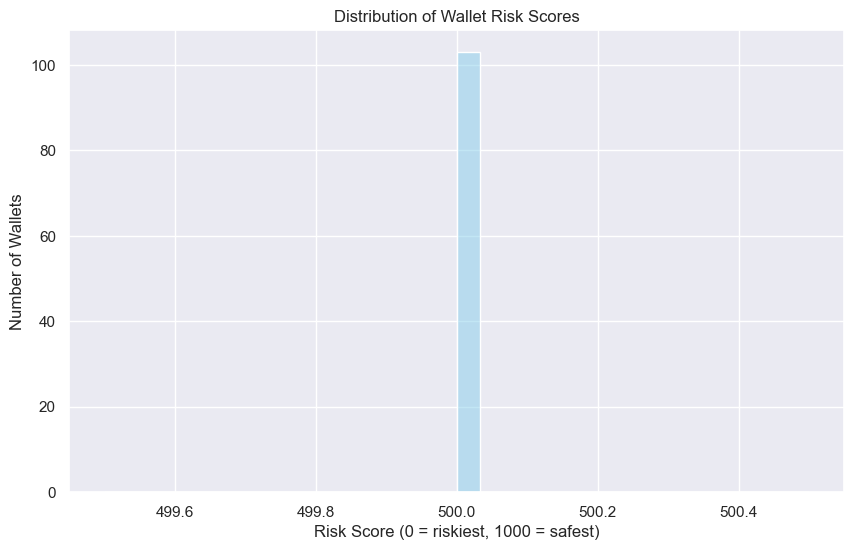

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(scored_df["score"], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Wallet Risk Scores")
plt.xlabel("Risk Score (0 = riskiest, 1000 = safest)")
plt.ylabel("Number of Wallets")
plt.show()


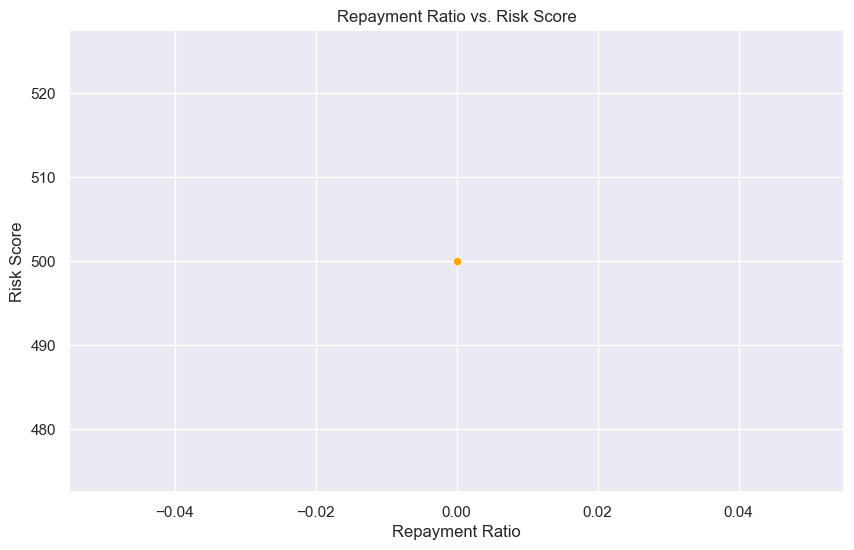

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=features_df, x="repayment_ratio", y=scored_df["score"], color="orange")
plt.title("Repayment Ratio vs. Risk Score")
plt.xlabel("Repayment Ratio")
plt.ylabel("Risk Score")
plt.grid(True)
plt.show()


C:\Users\91752\AppData\Local\Temp\ipykernel_58852\2553297349.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="wallet_id", y="score", data=top_risky, palette="Reds_r")


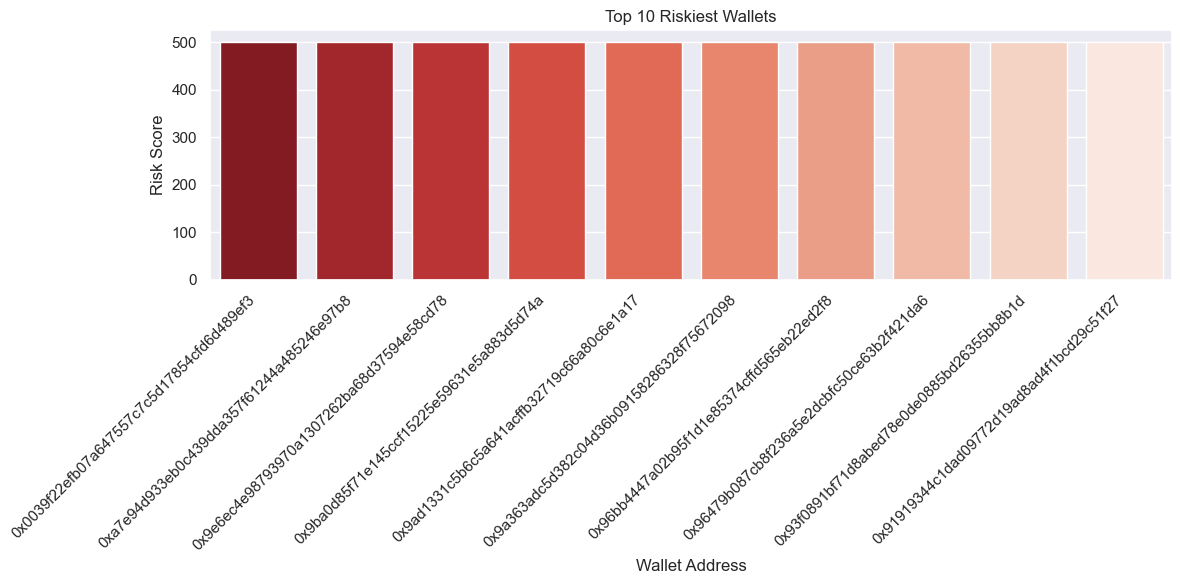

In [21]:
top_risky = scored_df.sort_values(by="score").head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x="wallet_id", y="score", data=top_risky, palette="Reds_r")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Riskiest Wallets")
plt.xlabel("Wallet Address")
plt.ylabel("Risk Score")
plt.tight_layout()
plt.show()
